# Image Recoloring
**TODO:**



## Setup




In [ ]:
import os
import glob
import time
import numpy as np
from numpy import arange
import pickle
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt                      
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision import models
from torchvision.models import VGG16_Weights
from torchvision.transforms import Compose, ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files

import PIL
from IPython.display import clear_output
import time
import cv2
from sklearn.metrics import mean_squared_error

!pip install torchmetrics
!pip install lpips
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

## Prepare dataset

The dataset is shared here https://drive.google.com/file/d/1PKDBVy1rmymKTKLTlB6iLQI1GLXcEpl0/view?usp=sharing. Add a shortcut to your own google drive and mount drive on google colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/COCOdataset.zip
!rm -rf /content/__MACOSX

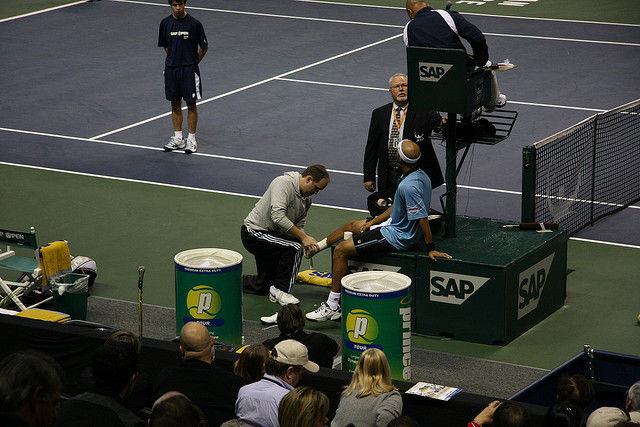

In [ ]:
# to see if the dataset is working correctly
coco_path = '/content/val2014'
dataset = get_image_files(coco_path)   
img = PIL.Image.open(dataset[1])
img

In [ ]:
# basic info of the dataset
print("Dataset length: ", len(dataset))
print("Images dimensions: ", img.size)

Dataset length:  40504
Images dimensions:  (640, 427)


In [ ]:
paths_list = glob.glob(coco_path+"/*.jpg")                              # paths_list is a list with all the image files names of our dataset

np.random.seed(123)                                                     # Seeding for reproducible results
if os.path.exists('/content/drive/MyDrive/weights_GAN/paths.npy')  and os.path.exists('/content/drive/MyDrive/weights_GAN/indexes.npy'):
    # Load paths from file
    paths_subset = np.load('/content/drive/MyDrive/weights_GAN/paths.npy')
    rand_indexes = np.load('/content/drive/MyDrive/weights_GAN/indexes.npy')
else:
    # Generate and save random paths and indexs                                        
    paths_subset = np.random.choice(paths_list, 35000, replace=False)       # Randomly choosing 35000 images from the list
    rand_indexes = np.random.permutation(35000)                             # Shuffling the indexes
    np.save('/content/drive/MyDrive/weights_GAN/paths.npy', paths_subset)
    np.save('/content/drive/MyDrive/weights_GAN/indexes.npy', rand_indexes)

train_indexes = rand_indexes[:25000]                                    # Using 25000 images for training
val_indexes = rand_indexes[25000:30000]                                 # Using 5000 images for validation
test_indexes = rand_indexes[30000:31000]                                # Using 1000 images for testing
train_paths = paths_subset[train_indexes]                               # Array with all the image files names for the training
test_paths = paths_subset[test_indexes]                                 # Array with all the image files names for the test
val_paths = paths_subset[val_indexes]                                   # Array with all the image files names for the validation

print("Training set length: "+str(len(train_paths)))
print("Test set length: "+str(len(test_paths)))
print("Validation set length: "+str(len(val_paths)))

Training set length: 25000
Test set length: 1000
Validation set length: 5000


## Dataset and Dataloader

In [ ]:
SIZE = 256   # fixed size of the images 

class image_coloring_dataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                # Data augmentation
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
            ])
        elif split == 'test':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
            
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return L, ab     #{'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

## Create the models

### Generator

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(64, 128, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(128, 256, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(256, 512, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(512, 512, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(512, 512, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(512, 512, down=True, act="leaky", use_dropout=False)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1), nn.ReLU()
        )

        # U-Net decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
        self.up1 = Block(512, 512, down=False, act="relu", use_dropout=True)
        self.up2 = Block(1024, 512, down=False, act="relu", use_dropout=True)
        self.up3 = Block(1024, 512, down=False, act="relu", use_dropout=True)
        self.up4 = Block(1024, 512, down=False, act="relu", use_dropout=False)
        self.up5 = Block(1024, 256, down=False, act="relu", use_dropout=False)
        self.up6 = Block(512, 128, down=False, act="relu", use_dropout=False)
        self.up7 = Block(256, 64, down=False, act="relu", use_dropout=False)
        # output size is 2 because Generator predicts 2 image channels
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, 2, kernel_size=4, stride=2, padding=1),   
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

def test():
    x = torch.randn((1, 1, 256, 256))
    model = Generator(in_channels=1)
    preds = model(x)
    print(model)
    print(preds.shape)

In [ ]:
test()

### Discriminator
The architecture for the PatchGAN Discriminator (70x70 patch) is:
 

1.   Convolutional layer with 64 filters, kernel size=4, stride=2, padding=1, LeakyRelu (with negative_slope=0.2)
2.   Convolutional layer with 128 filters, kernel size=4 stride=2, padding=1, LeakyRelu (with negative_slope=0.2) and with Batch Normalization
3.   Convolutional layer with 256 filters, kernel size=4 stride=2, padding=1, LeakyRelu (with negative_slope=0.2) and with Batch Normalization
4.   Convolutional layer with 512 filters, kernel size=4 stride=1, padding=1, LeakyRelu (with negative_slope=0.2) and with Batch Normalization


In [ ]:
class CNNBlockBN(nn.Module):
  def __init__(self, in_channels, out_channels, s=2):

    super().__init__()
    
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride=s, padding=1, bias=False, padding_mode="reflect"),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )
  
  def forward(self, x):
    return self.conv(x)

# CNN without Batch Normalization
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, s=2):

    super().__init__()
    
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride=s, padding=1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )
  
  def forward(self, x):
    return self.conv(x)

class Discriminator(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    features = [64, 128, 256, 512]

    self.model = nn.Sequential(
        CNNBlock(in_channels, features[0]),
        CNNBlockBN(features[0], features[1]),
        CNNBlockBN(features[1], features[2]),
        # last block with stride = 1
        CNNBlockBN(features[2], features[3], s=1),
        nn.Conv2d(features[3], 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")
    )
  
  def forward(self, x, y):
    x = torch.cat([x, y], dim=1)
    x = self.model(x)
    return x

In [ ]:
# test the model 
def test():
  # 1 image with 1 channels 256x256
  x = torch.randn((1, 1, 256, 256))
  # 1 image with 2 channels 256x256
  y = torch.randn((1, 2, 256, 256))
  model = Discriminator(in_channels = 3)
  preds = model(x, y)
  print(model)
  print(preds.shape)

test()

Discriminator(
  (model): Sequential(
    (0): CNNBlock(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNNBlockBN(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNNBlockBN(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): CNNBlockBN(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=Fa

Weights initialization

In [ ]:
def initialize_weights(model, init="normal"):
    classname = model.__class__.__name__
    if classname.find('Conv2d') != -1:
        if(init=="xavier"): 
          nn.init.xavier_uniform_(model.weight.data)
        if(init=="normal"):
          nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.2)
        nn.init.constant_(model.bias.data, 0)

## Training

###Utility functions

In [ ]:
def save_checkpoint(model, optimizer, filename):
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [ ]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
def labToRGB(L, ab):
  L = (L + 1.) * 50.
  ab = ab * 110.
  Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
  rgb_imgs = []
  for img in Lab:
    img_rgb = lab2rgb(img)
    rgb_imgs.append(img_rgb)
  return np.stack(rgb_imgs, axis=0)

def show_some_examples(gen, disc, l1, bce, val_loader):
  D_loss_values = []
  G_loss_values = []
  Total_gel_loss_values = []
  L1_loss_values = []
  D_fake_values = []
  D_real_values = []
  # TODO: elimina quello sbagliato
  D_real_sig_values = []
  D_fake_sig_values = []
  D_loss_sig_values = []

  x, y = next(iter(val_loader))
  x, y = x.to(device), y.to(device)
  #print("Shape of x: ", x.shape)
  #print("Shape of y: ", y.shape)
  # obtain original RGB image
  real_imgs = labToRGB(x, y)
  gen.eval()
  
  with torch.no_grad():
    y_fake = gen(x)
    # compute the losses
    # Discriminator
    D_real = disc(x, y)
    D_real_loss = bce(D_real, torch.ones_like(D_real))
    D_fake = disc(x, y_fake.detach())
    D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
    D_loss = D_real_loss + D_fake_loss

    # TODO: cancella quello sbagliato
    D_loss_sig_values.append(torch.sigmoid(D_fake).mean().item() + torch.sigmoid(D_real).mean().item())
    D_fake_sig_values.append(torch.sigmoid(D_fake).mean().item())
    D_real_sig_values.append(torch.sigmoid(D_real).mean().item())

    D_real_values.append(D_real_loss.item())
    D_fake_values.append(D_fake_loss.item())
    D_loss_values.append(D_loss.item())
    
    # Generator
    D_fake = disc(x, y_fake)
    G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
    L1 = l1(y_fake, y) * L1_LAMBDA
    G_loss = G_fake_loss + L1

    G_loss_values.append(G_fake_loss.item())
    L1_loss_values.append(L1.item())
    Total_gel_loss_values.append(G_loss.item())

  rgbImgs = labToRGB(x, y_fake)
  bsize = val_loader.batch_size
  # Set the size of the plot
  fig = plt.figure(figsize=(15, 8))
  for i in range(bsize):
    ax = plt.subplot(3, bsize, i + 1)
    ax.imshow(x[i][0].cpu(), cmap='gray')
    ax.axis("off")
    ax = plt.subplot(3, bsize, i + 1 + bsize)
    ax.imshow(rgbImgs[i])
    ax.axis("off")
    ax = plt.subplot(3, bsize, i + 1 + bsize*2)
    ax.imshow(real_imgs[i])
    ax.axis("off")
  plt.show()

  gen.train()
  # TODO: cancella quello sbagliato
  return {'Gen_loss': np.mean(G_loss_values),
            'Total_gen_loss' : np.mean(Total_gel_loss_values), 
            'L1_loss' : np.mean(L1_loss_values),
            'Disc_loss' : np.mean(D_loss_values),
            'D_fake' : np.mean(D_fake_values),
            'D_real' : np.mean(D_real_values),
            'Disc_loss_sig' : np.mean(D_loss_sig_values),
            'D_fake_sig' : np.mean(D_fake_sig_values),
            'D_real_sig' : np.mean(D_real_sig_values)
            }



###Hyper parameters



In [ ]:
LOAD_MODEL = True
SAVE_MODEL = True
TEST = True

In [ ]:
L1_LAMBDA = 100
NUM_EPOCHS = 100
BATCH_SIZE = 16    # sul video è 16; paper è 4 (o da 1 a 10)
LR = 0.0002 
BETA1 = 0.5
BETA2 = 0.999
CHECKPOINT_DISC = "/content/drive/MyDrive/weights_GAN/disc.pth.tar"
CHECKPOINT_GEN = "/content/drive/MyDrive/weights_GAN/gen.pth.tar"
TRAIN_LOSSES = "/content/drive/MyDrive/weights_GAN/loss_train_data.pkl"
VAL_LOSSES = "/content/drive/MyDrive/weights_GAN/loss_val_data.pkl"

In [ ]:
if torch.cuda.is_available():
  print('GPU availble')
  # Define the device (here you can select which GPU to use if more than 1)
  device = torch.device("cuda")
else:
  print('GPU not availble')
  device = torch.device("cpu")

GPU availble


###Train loop

In [ ]:
def train_loop():
    # Track losses
    # TODO: cancella chiavi sbagliate
    history = {'Gen_loss' : [], 'Total_gen_loss' : [], 'L1_loss' : [], 'Disc_loss' : [], 'D_fake': [], 'D_real' : [], 'Disc_loss_sig' : [], 'D_fake_sig': [], 'D_real_sig' : []}
    history_val = {'Gen_loss' : [], 'Total_gen_loss' : [], 'L1_loss' : [], 'Disc_loss' : [], 'D_fake': [], 'D_real' : [], 'Disc_loss_sig' : [], 'D_fake_sig': [], 'D_real_sig' : []}
    # recover previous history
    try:
      history = pickle.load(open(TRAIN_LOSSES, 'rb'))
      history_val = pickle.load(open(VAL_LOSSES, 'rb'))
      # recover the number of epochs completed 
      e_completed = len(history['Gen_loss'])
      print("Number of epochs previously done: ", e_completed)
    except FileNotFoundError:
      e_completed = 0
      print("File of previous history not found")
    
    disc = Discriminator(in_channels = 3)
    gen = Generator(in_channels = 1)
    if not LOAD_MODEL:
      print('Initializing the weights...')
      disc.apply(initialize_weights)
      gen.apply(initialize_weights)
    disc.to(device)
    gen.to(device)

    # Optimizers definition 
    opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(BETA1, BETA2))
    opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(BETA1, BETA2))
    # Losses definition
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    # Load the model 
    if LOAD_MODEL:
        print('Loading the model from the last checkpoint...')
        print("=> Loading checkpoint for generator")
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LR)
        print("=> Loading checkpoint for discriminator")
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LR)

    # Load training set
    train_dataset = image_coloring_dataset(paths=train_paths, split='train')
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=os.cpu_count(),
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    # Load validation set 
    val_dataset = image_coloring_dataset(paths=test_paths, split='val')
    val_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)


    for epoch in range(NUM_EPOCHS - e_completed):
        loss_dict = training_step(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)

        # Save the losses history
        history['Gen_loss'].append(loss_dict['Gen_loss'])
        history['Total_gen_loss'].append(loss_dict['Total_gen_loss'])
        history['L1_loss'].append(loss_dict['L1_loss'])
        history['Disc_loss'].append(loss_dict['Disc_loss'])
        history['D_fake'].append(loss_dict['D_fake'])
        history['D_real'].append(loss_dict['D_real'])
        history['Disc_loss_sig'].append(loss_dict['Disc_loss_sig'])
        history['D_fake_sig'].append(loss_dict['D_fake_sig'])
        history['D_real_sig'].append(loss_dict['D_real_sig'])

        # Save weights
        # if epoch % 2 == 0 and epoch != 100 and epoch != 50:
        if SAVE_MODEL:
          print("=> Saving checkpoint for generator")
          save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
          print("=> Saving checkpoint for discriminator")
          save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

        print("Epoch completed: ", epoch+1+e_completed, "/", NUM_EPOCHS)
        for loss_name, loss_value in loss_dict.items():
          print(loss_name,": ", loss_value)
        print('\n')

        # Show some generated images for validation and compute the losses
        loss_dict_val = show_some_examples(gen, disc, L1_LOSS, BCE, val_loader)
        history_val['Gen_loss'].append(loss_dict_val['Gen_loss'])
        history_val['Total_gen_loss'].append(loss_dict_val['Total_gen_loss'])
        history_val['L1_loss'].append(loss_dict_val['L1_loss'])
        history_val['Disc_loss'].append(loss_dict_val['Disc_loss'])
        history_val['D_fake'].append(loss_dict_val['D_fake'])
        history_val['D_real'].append(loss_dict_val['D_real'])
        history_val['Disc_loss_sig'].append(loss_dict['Disc_loss_sig'])
        history_val['D_fake_sig'].append(loss_dict['D_fake_sig'])
        history_val['D_real_sig'].append(loss_dict['D_real_sig'])
    
        # save losses on files
        with open(TRAIN_LOSSES, 'wb') as fp:
          pickle.dump(history, fp)
          print('Dictionary of loss train values saved successfully to file')

        with open(VAL_LOSSES, 'wb') as fp:
          pickle.dump(history_val, fp)
          print('Dictionary of loss validation data saved successfully to file')


In [ ]:
def training_step(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler):
    loop = tqdm(loader, leave=True)
    G_loss_values = []
    G_loss_tot_values = []
    L1_values = []
    # TODO: elimina quello sbagliato
    D_real_sig_values = []
    D_fake_sig_values = []
    D_loss_sig_values = []
    D_real_values = []
    D_fake_values = []
    D_loss_values = []
    
    for idx, (x, y) in enumerate(loop):
        x = x.to(device)    # BW image
        y = y.to(device)    # original image

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = D_real_loss + D_fake_loss
            
        # TODO: elimina quello sbagliato
        D_real_sig_values.append(torch.sigmoid(D_real).mean().item())
        D_fake_sig_values.append(torch.sigmoid(D_fake).mean().item())
        D_loss_sig_values.append(torch.sigmoid(D_fake).mean().item() + torch.sigmoid(D_real).mean().item()) #D_loss.mean().item())
        
        D_real_values.append(D_real_loss.item())
        D_fake_values.append(D_fake_loss.item())
        D_loss_values.append(D_loss.item())

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

            G_loss_values.append(G_fake_loss.item())
            L1_values.append(L1.item())
            G_loss_tot_values.append(G_loss.item())

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Every 10 batchs show the loss
        if idx % 10 == 0:
            loop.set_postfix(
                D_real=D_real_loss.item(),  #D_real=torch.sigmoid(D_real).mean().item(), 
                D_fake=D_fake_loss.item(),  #D_fake=torch.sigmoid(D_fake).mean().item(),
                Gen_loss=G_fake_loss.item(),
                Total_gen_loss=G_loss.item(),
                Disc_loss=D_loss.item(),
            )

    # TODO: cancellare quello sbagliato
    return {'Gen_loss': np.mean(G_loss_values),
            'Total_gen_loss' : np.mean(G_loss_tot_values), 
            'L1_loss' : np.mean(L1_values),
            'Disc_loss' : np.mean(D_loss_values),
            'D_fake' : np.mean(D_fake_values),
            'D_real' : np.mean(D_real_values),
            'Disc_loss_sig' : np.mean(D_loss_sig_values),
            'D_fake_sig' : np.mean(D_fake_sig_values),
            'D_real_sig' : np.mean(D_real_sig_values)
            }
      

### Start Training

In [ ]:
if not TEST:
  train_loop()

### Plot train and validation losses

In [ ]:
# Load the training and validation loss dictionaries
train_losses = pickle.load(open(TRAIN_LOSSES, 'rb')) 
val_losses = pickle.load(open(VAL_LOSSES, 'rb'))
G_loss = train_losses['Gen_loss']
D_loss = train_losses['Disc_loss']
D_fake = train_losses['D_fake']
D_real = train_losses['D_real']
Total_gen_loss = train_losses['Total_gen_loss']
L1_loss = train_losses['L1_loss']

G_loss_val = val_losses['Gen_loss']
D_loss_val = val_losses['Disc_loss']
D_fake_val = val_losses['D_fake']
D_real_val = val_losses['D_real']
Total_gen_loss_val = val_losses['Total_gen_loss']
L1_loss_val = val_losses['L1_loss']

def plot_train_val_loss(n_epochs, train_values, val_values, title):
  epochs = range(1, n_epochs+1)
  plt.figure(figsize=(10,5))
  plt.plot(epochs, train_values, label='Training Loss')
  plt.plot(epochs, val_values, label='Validation Loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  # Set the tick locations
  plt.xticks(arange(1, n_epochs+1, 3))
  # Display the plot
  plt.legend(loc='best')
  plt.show()

def plot_gen_disc_loss(n_epochs, gen_values, disc_values, title):
  epochs = range(1, n_epochs+1)
  plt.figure(figsize=(10,5))
  plt.plot(epochs, gen_values, label='Generator Loss')
  plt.plot(epochs, disc_values, label='Discriminator Loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  # Set the tick locations
  plt.xticks(arange(1, n_epochs+1, 1))
  # Display the plot
  plt.legend(loc='best')
  plt.show()

def plot_loss(n_epochs, loss_values, title, label):
  epochs = range(1, n_epochs+1)
  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss_values, label=label)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  # Set the tick locations
  plt.xticks(arange(1, n_epochs+1, 1))
  # Display the plot
  #plt.legend(loc='best')
  plt.show()


In [ ]:
print("Epochs done so far: ", len(G_loss))

Epochs done so far:  100


In [ ]:
plot_gen_disc_loss(len(G_loss), G_loss, D_loss, "Generator and Discriminator loss")

In [ ]:
plot_loss(len(G_loss), G_loss, "Generator GAN loss", "Gen GAN loss")
plot_loss(len(Total_gen_loss), Total_gen_loss, "Generator GAN Loss + L1 loss", "Total gen loss")
plot_loss(len(G_loss), G_loss, "Disciminator GAN loss", "Disc GAN loss")

In [ ]:
plot_gen_disc_loss(len(G_loss_val), G_loss_val, D_loss_val, "Generator and Discriminator loss during validation")

In [ ]:
plot_train_val_loss(len(G_loss), G_loss, G_loss_val, 'Training and Validation Loss for Generator')

In [ ]:
plot_train_val_loss(len(D_loss), D_loss, D_loss_val, 'Training and Validation Loss for Discriminator')

## Testing

In [ ]:
import matplotlib.gridspec as gridspec

def generate_images(gen, test_loader, index):
  for idx, (x, y) in enumerate(test_loader):
    if idx == index:
      x, y = x.to(device), y.to(device)
      break

  # obtain original RGB image
  real_imgs = labToRGB(x, y)
  gen.eval()
  with torch.no_grad():
    y_fake = gen(x)
    rgbImgs = labToRGB(x, y_fake)
  
  # Plot the images
  bsize = test_loader.batch_size

  fig = plt.figure(figsize=(8, 8))  # Adjust the figure size

  # Create a gridspec with custom widths and heights for each subplot
  gs = gridspec.GridSpec(3, bsize, wspace=0.1, hspace=0.1, width_ratios=[0.1, 0.1, 0.1])

  for i in range(bsize):
      ax = fig.add_subplot(gs[0, i])
      ax.imshow(x[i][0].cpu(), cmap='gray')
      ax.axis("off")

      ax = fig.add_subplot(gs[1, i])
      ax.imshow(rgbImgs[i])
      ax.axis("off")

      ax = fig.add_subplot(gs[2, i])
      ax.imshow(real_imgs[i])
      ax.axis("off")

  plt.show()
  
  gen.train()

### Evaluation metrics

In [ ]:
def compute_metrics(gen, test_loader):
  VGG16_sim_values = []
  mse_values = []
  percep_values = []
  start = time.time()

  for idx, (x, y) in enumerate(test_loader):
    # Clear the output
    clear_output(wait=True)
    print("Compting metrics for image: ", idx+1, "/1000")
    x = x.to(device)    #image in L
    y = y.to(device)    #image in ab

    # obtain original RGB image
    real_img = labToRGB(x, y)
    gen.eval()
    with torch.no_grad():
      y_fake = gen(x)
      # obtain generated img
      rgb_fake = labToRGB(x, y_fake)
    gen.train()
    
    #------ Computing metrics ------ 
    VGG16_sim_values.append(VGG16_similarity(real_img, rgb_fake))
    mse_values.append(mse_ab(y, y_fake))
    percep_values.append(perceptual_similarity(x, y, y_fake))

    print("Test VGG16 similarity: ", VGG16_sim_values[-1])
    print("Test mse: ", mse_values[-1])
    print("Test perceptual similarity: ", percep_values[-1])
    print("\n")

  end = time.time()
  print("Execution time:", end - start)

  print("Mean VGG16 cosine similarity: ", np.mean(VGG16_sim_values))
  print("Mean MSE: ", np.mean(mse_values))
  print("Mean perceptual similarity: ", np.mean(percep_values))


#### VGG16 Cosine similarity

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out



In [ ]:
def cosine_similarity(vector1, vector2):
    # Compute the dot product between the vectors
    dot_product = np.dot(vector1, vector2.T)
    # Compute the Euclidean norms of the vectors
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    # Compute the cosine similarity
    return dot_product / (norm1 * norm2)

def VGG16_similarity(realRGB, fakeRGB):
  realRGB = realRGB.squeeze()
  fakeRGB = fakeRGB.squeeze()
  # Scale the image array from [0, 1] to [0, 255]
  realRGB = (realRGB * 255).astype(np.uint8)
  fakeRGB = (fakeRGB * 255).astype(np.uint8)
  
  # Create a figure with two subplots with the two images
  fig, axes = plt.subplots(1, 2)
  axes[0].imshow(realRGB)
  axes[0].axis('off')
  axes[1].imshow(fakeRGB)
  axes[1].axis('off')
  plt.subplots_adjust(wspace=0.1)
  plt.show()
  
  # Initialize the model
  model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
  new_model = FeatureExtractor(model)
  # Change the device to GPU
  new_model = new_model.to(device)

  # Transform for the image, so it becomes readable with the model
  transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(512),
    transforms.Resize(448),
    transforms.ToTensor()                              
  ])

  realRGB = transform(realRGB)
  fakeRGB = transform(fakeRGB)
	# Reshape the image. PyTorch model reads 4-dimensional tensor
	# [batch_size, channels, width, height]
  realRGB = realRGB.reshape(1, 3, 448, 448)
  fakeRGB = fakeRGB.reshape(1, 3, 448, 448)
  realRGB = realRGB.to(device)
  fakeRGB = fakeRGB.to(device)
	# We only extract features, so we don't need gradient
  with torch.no_grad():
		# Extract the feature from the image
    featureR = new_model(realRGB)
    featureF = new_model(fakeRGB)
	# Convert to NumPy Array, Reshape it, and save it to features variable
  features_real = featureR.cpu().detach().numpy().reshape(-1)
  features_fake = featureF.cpu().detach().numpy().reshape(-1)

  # Compute cosine similarity between the two vectors
  return cosine_similarity(features_fake, features_real)



#### MSE on ab 

In [ ]:
def mse_ab(real, fake):
    real = real.cpu()
    real = real.squeeze().permute(1, 2, 0).numpy()
    fake = fake.cpu()
    fake = fake.squeeze().permute(1, 2, 0).numpy()
    # Flatten the vectors to 1D arrays
    real_flat = real.flatten()
    fake_flat = fake.flatten()
    # Compute the mean squared error between the flattened vectors
    return mean_squared_error(real_flat, fake_flat)

#### Perceptual similarity

In [ ]:
class ImprovedGANLoss(nn.Module):
  def __init__(self, backbone_network):
     super().__init__()
     self.loss = LearnedPerceptualImagePatchSimilarity(net_type=backbone_network)

  def normalize_tensor_values(self, input_tensor):
    flattened_output = input_tensor.view(input_tensor.shape[0], -1, 1, 1)
    min, _ = torch.min(flattened_output, dim=1, keepdim=True)
    max, _ = torch.max(flattened_output, dim=1, keepdim=True)
    input_tensor = (input_tensor - min) / (max - min)
    return input_tensor

  def __call__(self, real_preds, fake_preds):
    real_image = self.normalize_tensor_values(real_preds)
    fake_image = self.normalize_tensor_values(fake_preds)
    return self.loss(real_image, fake_image)

In [ ]:
def perceptual_similarity(x, y, y_fake):
  perceptual_loss = ImprovedGANLoss("vgg").to(device)

  #generate a fake image and obtain the discriminator labels
  fake_image = torch.cat([x, y_fake], dim=1)
  fake_preds = D_fake

  #generate an Lab image with L level at a constat value
  bs = x.shape[0]
  base_image = torch.full((bs,1,256,256),0).cuda()

  #generate the fake image and compute discriminator labels
  fake_image_based = torch.cat([base_image, y_fake], dim=1)

  #get real_image, helpful for the perceptual loss function
  real_image_based = torch.cat([base_image, y], dim=1)
            
  PERCEP_loss = perceptual_loss(real_image_based, fake_image_based)

  return 1 - PERCEP_loss.item()

### Start testing

In [ ]:
if TEST:
  # Load the from the latest checkpoint on gdrive
  print('--> TESTING <--')
  gen = Generator(in_channels = 1)
  gen.to(device)
  opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(BETA1, BETA2))
  BCE = nn.BCEWithLogitsLoss()  # forse non serve
  L1_LOSS = nn.L1Loss() # forse non serve

  load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LR)
  print('Generator model loaded.')

  # Loading test set 
  test_dataset = image_coloring_dataset(paths=test_paths, split='test')
  test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)
  # Loader for compute the metrics (batch size = 1)
  test_loader_metric = DataLoader(test_dataset, batch_size=1, shuffle=False)
  print('Test set loaded.')

--> TESTING <--
Generator model loaded.
Test set loaded.


Run the following cell to see the generation of images and to compute the evaluation metrics on the test set.
* 1st line --> BM images
* 2nd line --> Gerated images
* 3rd line --> Ground truth

In [ ]:
if TEST:
  generate_images(gen, test_loader, 1)
  #compute_metrics(gen, test_loader_metric)